In [1]:
# !pip install networkx
# !pip install fibheap

In [2]:
import random
import numpy as np
import math
import networkx as nx
import fibheap
import matplotlib.pyplot as plt


# requires networkx and fibheap

In [3]:
# Function to generate random coordinates for N stops in LxL area
def generate_stops(N, L):
    return np.random.uniform(0, L, (N, 2)) 

# Function to compute Euclidean distance
def euclidean_distance(node_1, node_2):
    return np.linalg.norm(node_1 - node_2)

# Create a multigraph with multiple connections between nodes
def create_multigraph(stops, num_connections=2):
    G = nx.MultiGraph()
    N = stops.shape[0]

    for i in range(N):
        G.add_node(i, pos=stops[i])

    connections = []
    
    for i in range(N):
        for j in range(i + 1, N):  # Ensure no self-loops
            for k in range(random.randint(1, num_connections)):  # Multiple connections
                path_id = f"P{i}{j}_{k}"  # Unique path ID
                weight = euclidean_distance(stops[i], stops[j]) * random.uniform(0.8, 1.5)  # Vary weight
                connections.append((i, j, path_id, weight))
    
    for (i, j, path_id, weight) in connections:
        G.add_edge(i, j, key=path_id, weight=weight)

    return G

def dijkstra_multigraph(graph, start, end):
    fib_heap = fibheap.Fheap()
    distances = {node: float('inf') for node in graph.nodes}
    predecessors = {node: None for node in graph.nodes}
    heap_nodes = {}

    distances[start] = 0

    for node in graph.nodes:
        heap_nodes[node] = fibheap.Node(float('inf'))
        fib_heap.insert(heap_nodes[node])

    fib_heap.decrease_key(heap_nodes[start], 0)

    while fib_heap.num_nodes > 0:
        u_node = fib_heap.extract_min()
        u = None

        for key, heap_node in heap_nodes.items():
            if heap_node is u_node:
                u = key
                break

        if u is None:
            continue

        if u == end:
            break

        for _, v, key, data in graph.edges(u, keys=True, data=True):  # FIXED HERE
            weight = data['weight']
            if distances[u] + weight < distances[v]:
                distances[v] = distances[u] + weight
                predecessors[v] = (u, key)
                fib_heap.decrease_key(heap_nodes[v], distances[v])

    # Reconstruct shortest path
    path = []
    path_ids = []
    while end is not None:
        prev = predecessors[end]
        if prev is not None:
            path_ids.append(prev[1])
        path.append(end)
        end = prev[0] if prev else None

    return path[::-1], path_ids[::-1], distances[path[0]]

#Visualisation of path
def plot_graph(graph, stops, path):
    plt.figure(figsize=(8, 8))
    pos = {i: stops[i] for i in range(len(stops))}

    # Draw the full graph
    nx.draw(graph, pos, node_color='lightgray', with_labels=True, edge_color='gray')

    # Highlight the shortest path dynamically
    for i in range(len(path) - 1):
        nx.draw_networkx_edges(graph, pos, edgelist=[(path[i], path[i + 1])], width=3, edge_color='r')
        plt.pause(0.5)  # Pause for animation effect

    plt.show()

In [4]:
# Test Parameters
N, L = 5, 10  # 6 nodes in a 10x10 grid
stops = generate_stops(N, L)
graph = create_multigraph(stops, num_connections=3)  # Up to 3 different paths between nodes

# Run Dijkstra's algorithm on MultiGraph
start, end = np.random.randint(0, N, 2) 
shortest_path, path_ids, distance = dijkstra_multigraph(graph, start, end)
print(graph)

MultiGraph with 5 nodes and 17 edges


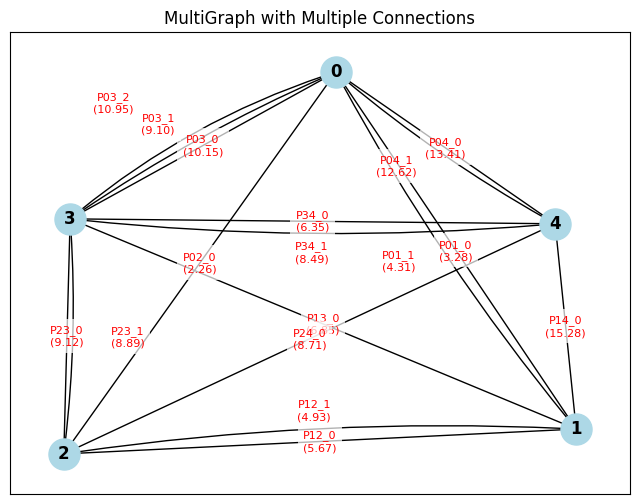

In [5]:
def plot_multigraph(graph):
    pos = nx.spring_layout(graph, seed=42)
    plt.figure(figsize=(8, 6))
    
    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color="lightblue")

    edge_counts = {}
    
    for u, v, key, data in graph.edges(keys=True, data=True):
        if (u, v) not in edge_counts:
            edge_counts[(u, v)] = 0
        edge_num = edge_counts[(u, v)]
        edge_counts[(u, v)] += 1
        
        # Different curve for each edge
        rad = 0.1 * (edge_num - (edge_counts[(u, v)]-1)/2)
        connection_style = f'arc3,rad={rad}'
        nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], 
                              connectionstyle=connection_style)

        weight = data['weight']
        edge_label = f"{key}\n({weight:.2f})"
        
        # Calculate label position with offset based on edge number
        mid_pos = (pos[u] + pos[v]) / 2
        direction = np.array([pos[v][1] - pos[u][1], pos[u][0] - pos[v][0]])
        direction = direction / np.linalg.norm(direction)
        
        # Offset perpendicular to the edge
        offset = 0.3 * (edge_num - (edge_counts[(u, v)]-1)/2)
        label_pos = mid_pos + offset * direction
        
        plt.text(label_pos[0], label_pos[1], edge_label, fontsize=8, color="red", 
                ha="center", va="center", bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    nx.draw_networkx_labels(graph, pos, font_size=12, font_weight="bold")
    plt.title("MultiGraph with Multiple Connections")
# Run visualization
plot_multigraph(graph)

From 2 to 3:
Shortest Path: [2, np.int64(3)]
Path IDs Used: ['P23_1']
Total Distance: 8.890321567965877


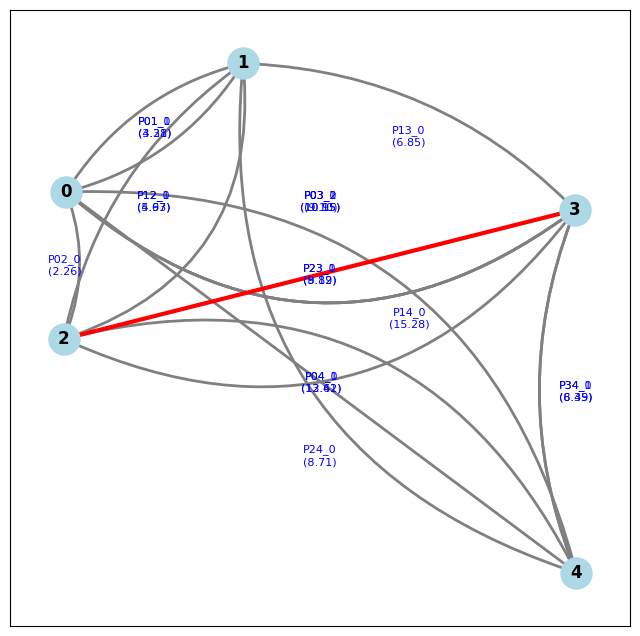

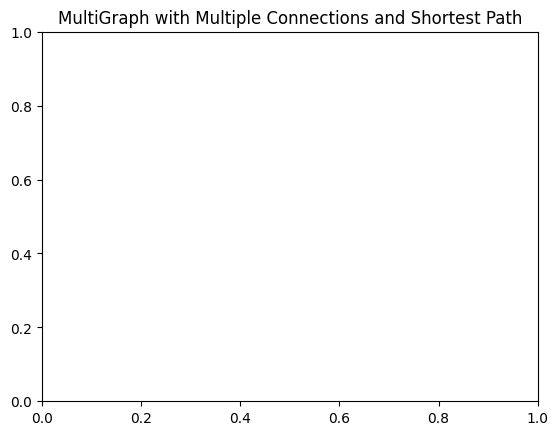

In [6]:
# Print results
print(f"From {start} to {end}:")
print("Shortest Path:", shortest_path)
print("Path IDs Used:", path_ids)
print("Total Distance:", distance)

def plot_multigraph_with_path(graph, stops, path, path_ids):
    plt.figure(figsize=(8, 8))
    pos = {i: stops[i] for i in range(len(stops))}

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_color="lightblue", node_size=500)

    # Draw all edges (including multiple connections)
    for u, v, key, data in graph.edges(keys=True, data=True):
        weight = data['weight']
        color = "gray"  # Default color

        # Check if this edge is part of the shortest path
        if (u, v, key) in zip(path[:-1], path[1:], path_ids) or (v, u, key) in zip(path[:-1], path[1:], path_ids):
            color = "red"  # Highlight selected edges

        # Draw edges with different curvatures
        nx.draw_networkx_edges(
            graph, pos, edgelist=[(u, v)], edge_color=color, width=2,
            connectionstyle=f'arc3,rad={0.2 * (hash(key) % 5 - 2)}'  # Vary curvature
        )

        # Label edges with path_id and weight
        mid_pos = (pos[u] + pos[v]) / 2
        plt.text(mid_pos[0], mid_pos[1], f"{key}\n({weight:.2f})", fontsize=8, color="blue", ha="center", va="center")

    # Draw node labels
    nx.draw_networkx_labels(graph, pos, font_size=12, font_weight="bold")

    # Animate highlighting of the shortest path
    for i in range(len(path) - 1):
        u, v, key = path[i], path[i + 1], path_ids[i]
        nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], width=3, edge_color='r')
        plt.pause(0.5)  # Pause for animation effect

    plt.title("MultiGraph with Multiple Connections and Shortest Path")
    plt.show()

# Run visualization
plot_multigraph_with_path(graph, stops, shortest_path, path_ids)


### ALPHA VERSION